# Deep Transfer Learning for Accurate Dog Breed Classification

In this we are using LFW(Labelled Faces in the Wild) dataset for Human Images.
 - You can find the dataset here https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

Where we are using the Stanford Dogs Dataset for the images of Dogs
 - You can find the dataset here https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

Our goal is to create an algorithm that can:
1. Detect whether an image contains a human or a dog.
2. Predict the dog breed if a dog is detected.
3. Suggest a resembling dog breed if a human is detected.

## Importing Dependencies

In [1]:
# Standard Libraries
import os
import time
import random
import ast
import shutil
from glob import glob

# Numerical & Data Processing
import numpy as np
import pandas as pd
import requests

# Computer Vision & Image Processing
import cv2
from PIL import Image, ImageFile

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# PyTorch & Torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets

# TensorFlow & Keras
import tensorflow  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50

## Importing Dataset

In [2]:
human_files = np.array(glob('data/Human_Images/*/*/*/*'))
dog_files = np.array(glob('data/Dog_Images/images/*/*'))

print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 20580 total dog images.


## Detecting Humans

I am using the HAAR classifier for human detection. It is a widely used object detection method that works as follows:  

- **Feature Extraction:** Uses HAAR-like features to detect patterns in images.  
- **Cascade Classifier:** Employs a series of classifiers trained on positive (human) and negative (non-human) samples.  
- **Boosting Algorithm:** Utilizes AdaBoost to improve detection accuracy by selecting the most relevant features.  
- **Real-Time Efficiency:** Works efficiently in real-time applications, making it suitable for tasks like face and body detection.  
- **Implementation:** Commonly used in OpenCV for tasks such as facial recognition and object tracking.  

The Number of faces in the given Image is/are: 8


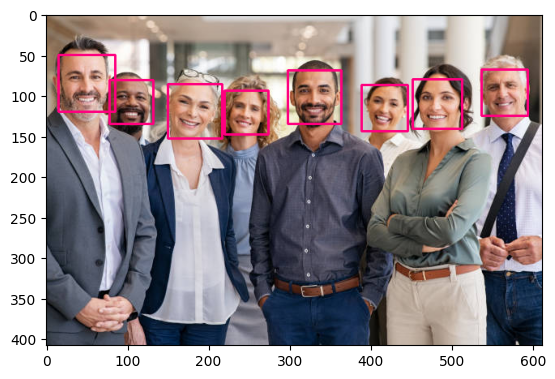

In [3]:
face_classifier = cv2.CascadeClassifier('/Users/vvyas/Desktop/Projects_for_resume/Projects/1_Project_Notebooks/haarcascades/haarcascade_frontalface_default.xml')

image = cv2.imread('../2_Practice_Notebooks/human_image.jpg')
# image = cv2.imread('../2_Practice_Notebooks/noface.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_classifier.detectMultiScale(gray, 1.23, 5)
number_of_faces = len(faces)

if number_of_faces==0:
    print("There are no faces detected in the given Image")
else:
    print(f'The Number of faces in the given Image is/are: {number_of_faces}')
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (127, 0, 255), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)

Before using any face detector, it is standard practice to convert images to grayscale. The `detectMultiScale` function applies the classifier stored in `face_cascade` and takes the grayscale image as input.

The `faces` variable is a NumPy array containing the detected faces, where each row represents a detected face. Each detected face is a 1D array with four values that define the bounding box:

- The first two values (`x`, `y`) represent the horizontal and vertical coordinates of the top-left corner.  
- The last two values (`w`, `h`) represent the width and height of the bounding box.

### Making a Face Detector

We will create a face detector that identifies human faces and returns `True` if a human face is detected.

In [4]:
def face_detector(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face = face_classifier.detectMultiScale(gray_image, 1.1, 5)
    return len(face)>0

In [5]:
face_detector('../2_Practice_Notebooks/human_image.jpg')

True

We can check the performance the HAAR face detector using the first 100 images from Dogs and Humans dataset

In [6]:
mini_dogs_set = dog_files[:100]
mini_human_set = human_files[:100]

human_count = 0
dog_count = 0

for file in tqdm(mini_human_set):
    if face_detector(file) == True:
        human_count += 1
        
for file in tqdm(mini_dogs_set):
    if face_detector(file) == True:
        dog_count += 1

print('The percentage of detected Human faces :{0:.0%}'.format(human_count / 100))
print('The percentage of detected Dog faces :{0:.0%}'.format(dog_count / 100))

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.84it/s]

The percentage of detected Human faces :99%
The percentage of detected Dog faces :20%


## Detection of Dogs

**Our objective is to Identify dogs in images using a pre-trained ResNet-50 model**.  

**Steps Involved**  

1. Download the ResNet-50 Model  
    - Utilizes pre-trained weights from ImageNet.  

2. Understanding ImageNet  
    - A large dataset designed for image classification and computer vision tasks.  
    - Contains over 10 million images linked via URLs.  
    - Includes 1,000 distinct object categories.  

3. Prediction Process  
    - An image is input into the ResNet-50 model.  
    - The model classifies the image based on ImageNet categories.  
    - If the predicted class corresponds to a dog breed, the presence of a dog is confirmed.

In [7]:
# Importing the Pre Trained model

from keras.applications.resnet50 import ResNet50

pre_trained_model = ResNet50(weights='imagenet')

## Preprocessing the Image

In [8]:
def preprocess_image(img_path):  
    """  
    Loads and resizes a single image to (224, 224, 3),  
    converting it into a 4D tensor.  
    
    Args:  
        img_path (str): Path to the image file.  
    
    Returns:  
        np.ndarray: 4D tensor with shape (1, 224, 224, 3).  
    """  
    img = image.load_img(img_path, target_size=(224, 224))  # Loads image in PIL.Image.Image format
    img_array = image.img_to_array(img)  # Converts to 3D tensor
    return img_array.reshape(1, 224, 224, 3)  # Converts and returns a 4D tensor  

def stack_images(img_paths):  
    """  
    Converts a list of image paths into a single stacked 4D tensor.  
    
    Args:  
        img_paths (list): List of image file paths.  
    
    Returns:  
        np.ndarray: 4D tensor with shape (N, 224, 224, 3).  
    """  
    return np.vstack([preprocess_image(img_path) for img_path in tqdm(img_paths)])

- **Purpose**: `np.vstack()` (vertical stack) is used to combine multiple arrays along the **first axis (axis=0)**.
- **Shape Transformation**:
  - Takes a list of arrays with shape **(1, 224, 224, 3)**.
  - Stacks them to form a **single 4D tensor** with shape **(N, 224, 224, 3)** (where `N` is the number of images).
- **Use Case**: Essential for deep learning models that require batched input.
- **Example**:
  ```python
  import numpy as np

  img1 = np.random.rand(1, 224, 224, 3)  # Shape: (1, 224, 224, 3)
  img2 = np.random.rand(1, 224, 224, 3)  # Shape: (1, 224, 224, 3)

  batch = np.vstack([img1, img2])
  print(batch.shape)  # Output: (2, 224, 224, 3)


In [9]:
# Checking the availability of CUDA

is_cuda = torch.cuda.is_available()

if is_cuda:
    pre_trained_model = pre_trained_model.cuda()

## Making predictions with the Pre Trained Model

**Preprocessing Required for ResNet Model**  

1. **Resize the Image** → Convert the input image to **(224, 224)** pixels (ResNet’s expected input size).  
2. **Convert to Tensor** → Transform the image into a **PyTorch tensor** (shape: **C×H×W** → (3, 224, 224)).  
3. **Normalize Pixel Values** → Apply **ImageNet mean & standard deviation**:  
   - **Mean**: `[0.485, 0.456, 0.406]`  
   - **Standard Deviation**: `[0.229, 0.224, 0.225]`  
4. **Add Batch Dimension** → Convert shape from **(3, 224, 224) → (1, 3, 224, 224)** for model input.  

In [10]:
def convert_image_to_tensor(img_path):    
    """ 
    Loads an image, converts it to RGB, resizes to (224, 224), and applies ResNet preprocessing. 
    
    Args:
        img_path (str): Path to the image file.
    
    Returns:
        torch.Tensor: Preprocessed image tensor with shape (1, 3, 224, 224).
    """    
    image = Image.open(img_path).convert('RGB')

    # Define preprocessing for ResNet
    transformation = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to ResNet input size
        transforms.ToTensor(),          # Convert to tensor (0-1 range)
        transforms.Normalize(           # Normalize using ImageNet mean & std
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Apply transformations and add batch dimension
    image = transformation(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
    
    return image

We perform **re-normalization** on the ResNet tensor for visualization purposes. The process involves:  

1. **Detaching the tensor from the computation graph**, moving it to the CPU, and converting it into a NumPy array.  
2. **Reshaping it back to the original image format** (Height, Width, Channels).  
3. **Reversing the normalization** by multiplying with the standard deviation and adding the mean.  
4. **Applying clipping (`np.clip`)** to ensure pixel values remain within a valid range for proper visualization.

In [11]:
def resnet_tensor_to_image(tensor):
    """
    Converts a preprocessed ResNet tensor back to an image for visualization.
    
    Args:
        tensor (torch.Tensor): Preprocessed image tensor with shape (1, 3, 224, 224).
    
    Returns:
        np.ndarray: Image in (224, 224, 3) format with pixel values in [0,1].
    """
    # Move tensor to CPU, detach from computation graph, and convert to NumPy
    image = tensor.cpu().clone().detach().numpy().squeeze()  # Shape: (3, 224, 224)

    # Convert from (C, H, W) to (H, W, C)
    image = image.transpose(1, 2, 0)

    # Reverse normalization (undo mean & std normalization applied during preprocessing)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean  # Rescale to original pixel range

    # Clip values to ensure they are in valid [0,1] range
    image = np.clip(image, 0, 1)

    return image

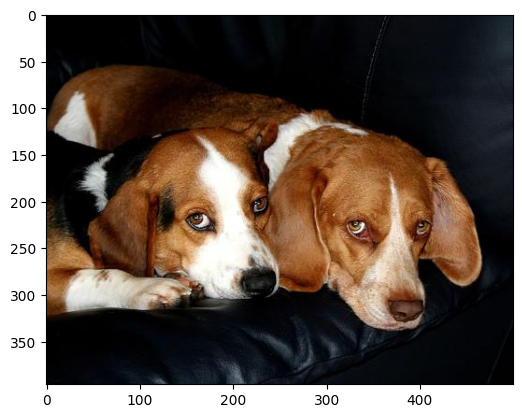

In [12]:
image_path = "data/Dog_Images/images/n02088364-beagle/n02088364_10731.jpg"

dog_image = Image.open(image_path)
plt.imshow(dog_image)
plt.show()

torch.Size([1, 3, 224, 224])


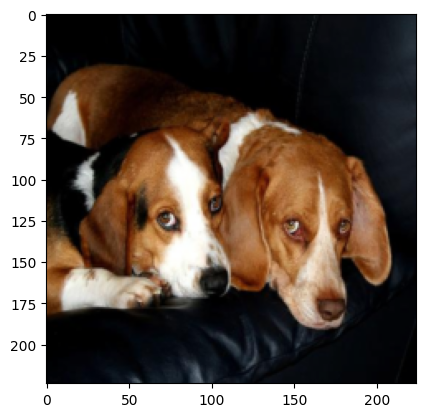

In [13]:
test_tensor = convert_image_to_tensor(image_path)
print(test_tensor.shape)
plt.imshow(resnet_tensor_to_image(test_tensor))

This output confirms that our conversion process was correctly implemented

In [14]:
def ResNet_predict(img_path):
    """
    Predicts the class label of an image using a pre-trained ResNet50 model.

    Args:
        img_path (str): Path to the image file.

    Returns:
        tuple: (Predicted class ID, Human-readable class label).
    """
    # Load and preprocess the image
    img = tensorflow.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tensorflow.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Apply ResNet preprocessing

    # Get model predictions
    preds = pre_trained_model.predict(img_array)
    pred_class_id = np.argmax(preds)

    # Decode predictions to get class ID and label
    decoded_preds = decode_predictions(preds, top=1)[0][0]  # Get top prediction
    
    class_label = decoded_preds[1]  # Human-readable class label (e.g., "Pekinese")

    return class_label, pred_class_id  # Return both class ID and label

In [15]:
# URL containing ImageNet class labels mapping
LABELS_MAP_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt"

def get_human_readable_label_for_class_id(pred_class_id):
    """
    Fetches the human-readable class label for a given ImageNet class ID.
    
    Args:
        class_id (int): Predicted class ID.
    
    Returns:
        str: Human-readable label for the class.
    """
    labels = ast.literal_eval(requests.get(LABELS_MAP_URL).text)  # Fetch and convert text data into a dictionary
    print(f"Label:{labels[pred_class_id]}")
    return labels[pred_class_id]

# Predict the class of an image using ResNet
path_to_image = "data/Dog_Images/images/n02099601-golden_retriever/n02099601_1028.jpg"
class_label, pred_class_id = ResNet_predict(path_to_image)

# Directly print the class label obtained from `decode_predictions`
print(f"Predicted class for image: {class_label.upper()}")  # Example: "PEKINESE"
print(f"Predicted class id: {pred_class_id}")

class_description = get_human_readable_label_for_class_id(pred_class_id)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class for image: GOLDEN_RETRIEVER
Predicted class id: 207
Label:golden retriever


## Making a Dog Detector

The range **151-268** is specific to the **ImageNet** dataset's class index mapping. In **ImageNet**, the labels are numbered from **0 to 999**, corresponding to various objects, animals, and scenes.  

**Why 151-268?**

In the **ImageNet** dataset, dog breeds are grouped together in a continuous range from **class index 151 to 268**. This means that any image classified with an index in this range corresponds to a specific dog breed.  

For example:  
- **151 → Chihuahua**  
- **152 → Japanese Spaniel**  
- **153 → Maltese Dog**  
- **...**  
- **268 → Mexican Hairless**  

This makes it easy to determine whether an image contains a dog—by simply checking if its predicted class index falls within this range.  

**Why should we use ImageNet dataset for verification and not the Stanford dataset?**
- Because the pre trained model which we are using is trained on the ImageNet dataset.
- This means its predictions are based on ImageNet’s 1,000 classes, where dogs are indexed from 151 to 268.

In [16]:
def dog_detector(img_path):
    """
    Determines if an image contains a dog based on the ResNet50 model's prediction.

    Args:
        img_path (str): Path to the image file.

    Returns:
        bool: True if a dog is detected (class ID between 151-268), False otherwise.
    """
    _, pred_class_id = ResNet_predict(img_path)  # Get predicted class index
    return 151 <= pred_class_id <= 268  # Check if index falls in the dog category range

In [17]:
dog_detector('data/Dog_Images/images/n02099601-golden_retriever/n02099601_1028.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


np.True_

### Checking the Dog Detector on the mini data

In [18]:
dog_alike_human = 0
dog_count = 0

# Total samples
total_human_images = len(mini_human_set)
total_dog_images = len(mini_dogs_set)

# Custom tqdm settings
tqdm_bar_format = "{l_bar}{bar:30}{r_bar}"  # Adjust bar width (30 units)

# Check humans that look like dogs
for i in tqdm(range(total_human_images),
              desc="Processing Human Images",
              bar_format=tqdm_bar_format, 
              colour="blue"):
    if dog_detector(mini_human_set[i]):
        dog_alike_human += 1

print("\n")

# Check actual dog images
for i in tqdm(range(total_dog_images),
              desc="Processing Dog Images",
              bar_format=tqdm_bar_format, 
              colour="green"):
    if dog_detector(mini_dogs_set[i]):
        dog_count += 1

# Calculate percentages
human_dog_percentage = (dog_alike_human / total_human_images) * 100
dog_percentage = (dog_count / total_dog_images) * 100

# Print results
print(f"Percentage of Human images that look like a dog: {human_dog_percentage:.2f}%")
print(f"Percentage of Dog images detected correctly: {dog_percentage:.2f}%")

Processing Human Images:   0%|                              | 0/100 [00:00<?, ?i

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Human Images:   1%|▎                             | 1/100 [00:00<00:27

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Human Images:   2%|▌                             | 2/100 [00:00<00:26

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Human Images:   3%|▉                             | 3/100 [00:00<00:26

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:   4%|█▏                            | 4/100 [00:01<00:26

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Human Images:   5%|█▌                            | 5/100 [00:01<00:25

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:   6%|█▊                            | 6/100 [00:01<00:25

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Human Images:   7%|██                            | 7/100 [00:01<00:25

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:   8%|██▍                           | 8/100 [00:02<00:24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:   9%|██▋                           | 9/100 [00:02<00:24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:  10%|███                           | 10/100 [00:02<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Human Images:  11%|███▎                          | 11/100 [00:02<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Human Images:  12%|███▌                          | 12/100 [00:03<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Human Images:  13%|███▉                          | 13/100 [00:03<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Human Images:  14%|████▏                         | 14/100 [00:03<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Human Images:  15%|████▌                         | 15/100 [00:04<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Human Images:  16%|████▊                         | 16/100 [00:04<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processing Human Images:  17%|█████                         | 17/100 [00:04<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:  18%|█████▍                        | 18/100 [00:04<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  19%|█████▋                        | 19/100 [00:05<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Human Images:  20%|██████                        | 20/100 [00:05<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Human Images:  21%|██████▎                       | 21/100 [00:05<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processing Human Images:  22%|██████▌                       | 22/100 [00:06<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Human Images:  23%|██████▉                       | 23/100 [00:06<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Human Images:  24%|███████▏                      | 24/100 [00:06<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Human Images:  25%|███████▌                      | 25/100 [00:06<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Human Images:  26%|███████▊                      | 26/100 [00:07<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  27%|████████                      | 27/100 [00:07<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Processing Human Images:  28%|████████▍                     | 28/100 [00:07<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  29%|████████▋                     | 29/100 [00:08<00:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Human Images:  30%|█████████                     | 30/100 [00:08<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  31%|█████████▎                    | 31/100 [00:08<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:  32%|█████████▌                    | 32/100 [00:08<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Human Images:  33%|█████████▉                    | 33/100 [00:09<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:  34%|██████████▏                   | 34/100 [00:09<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Human Images:  35%|██████████▌                   | 35/100 [00:09<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:  36%|██████████▊                   | 36/100 [00:10<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Human Images:  37%|███████████                   | 37/100 [00:10<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Human Images:  38%|███████████▍                  | 38/100 [00:10<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Human Images:  39%|███████████▋                  | 39/100 [00:10<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Human Images:  40%|████████████                  | 40/100 [00:11<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:  41%|████████████▎                 | 41/100 [00:11<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Human Images:  42%|████████████▌                 | 42/100 [00:11<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  43%|████████████▉                 | 43/100 [00:11<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Human Images:  44%|█████████████▏                | 44/100 [00:12<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Human Images:  45%|█████████████▌                | 45/100 [00:12<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  46%|█████████████▊                | 46/100 [00:12<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Human Images:  47%|██████████████                | 47/100 [00:13<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Processing Human Images:  48%|██████████████▍               | 48/100 [00:13<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Processing Human Images:  49%|██████████████▋               | 49/100 [00:13<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Human Images:  50%|███████████████               | 50/100 [00:13<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processing Human Images:  51%|███████████████▎              | 51/100 [00:14<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Processing Human Images:  52%|███████████████▌              | 52/100 [00:14<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  53%|███████████████▉              | 53/100 [00:14<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Human Images:  54%|████████████████▏             | 54/100 [00:14<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:  55%|████████████████▌             | 55/100 [00:15<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Human Images:  56%|████████████████▊             | 56/100 [00:15<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:  57%|█████████████████             | 57/100 [00:15<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Human Images:  58%|█████████████████▍            | 58/100 [00:16<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processing Human Images:  59%|█████████████████▋            | 59/100 [00:16<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  60%|██████████████████            | 60/100 [00:16<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Human Images:  61%|██████████████████▎           | 61/100 [00:16<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Human Images:  62%|██████████████████▌           | 62/100 [00:17<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  63%|██████████████████▉           | 63/100 [00:17<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Processing Human Images:  64%|███████████████████▏          | 64/100 [00:17<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Human Images:  65%|███████████████████▌          | 65/100 [00:18<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Human Images:  66%|███████████████████▊          | 66/100 [00:18<00:1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Human Images:  67%|████████████████████          | 67/100 [00:18<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Human Images:  68%|████████████████████▍         | 68/100 [00:18<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Human Images:  69%|████████████████████▋         | 69/100 [00:19<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Human Images:  70%|█████████████████████         | 70/100 [00:19<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:  71%|█████████████████████▎        | 71/100 [00:19<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  72%|█████████████████████▌        | 72/100 [00:20<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Human Images:  73%|█████████████████████▉        | 73/100 [00:20<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Human Images:  74%|██████████████████████▏       | 74/100 [00:20<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Human Images:  75%|██████████████████████▌       | 75/100 [00:20<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Human Images:  76%|██████████████████████▊       | 76/100 [00:21<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Human Images:  77%|███████████████████████       | 77/100 [00:21<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:  78%|███████████████████████▍      | 78/100 [00:21<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Human Images:  79%|███████████████████████▋      | 79/100 [00:22<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Processing Human Images:  80%|████████████████████████      | 80/100 [00:22<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  81%|████████████████████████▎     | 81/100 [00:22<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Human Images:  82%|████████████████████████▌     | 82/100 [00:22<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Human Images:  83%|████████████████████████▉     | 83/100 [00:23<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processing Human Images:  84%|█████████████████████████▏    | 84/100 [00:23<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Human Images:  85%|█████████████████████████▌    | 85/100 [00:23<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Human Images:  86%|█████████████████████████▊    | 86/100 [00:24<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Human Images:  87%|██████████████████████████    | 87/100 [00:24<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Human Images:  88%|██████████████████████████▍   | 88/100 [00:24<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processing Human Images:  89%|██████████████████████████▋   | 89/100 [00:24<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  90%|███████████████████████████   | 90/100 [00:25<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Human Images:  91%|███████████████████████████▎  | 91/100 [00:25<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Human Images:  92%|███████████████████████████▌  | 92/100 [00:25<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  93%|███████████████████████████▉  | 93/100 [00:26<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Human Images:  94%|████████████████████████████▏ | 94/100 [00:26<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Human Images:  95%|████████████████████████████▌ | 95/100 [00:26<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Human Images:  96%|████████████████████████████▊ | 96/100 [00:26<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  97%|█████████████████████████████ | 97/100 [00:27<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processing Human Images:  98%|█████████████████████████████▍| 98/100 [00:27<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Human Images:  99%|█████████████████████████████▋| 99/100 [00:27<00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Human Images: 100%|██████████████████████████████| 100/100 [00:27<00:


Processing Dog Images:   0%|                              | 0/100 [00:00<?, ?it/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processing Dog Images:   1%|▎                             | 1/100 [00:00<00:28, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Dog Images:   2%|▌                             | 2/100 [00:00<00:27, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Dog Images:   3%|▉                             | 3/100 [00:00<00:26, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processing Dog Images:   4%|█▏                            | 4/100 [00:01<00:27, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Dog Images:   5%|█▌                            | 5/100 [00:01<00:26, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Dog Images:   6%|█▊                            | 6/100 [00:01<00:25, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Dog Images:   7%|██                            | 7/100 [00:01<00:26, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Dog Images:   8%|██▍                           | 8/100 [00:02<00:25, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:   9%|██▋                           | 9/100 [00:02<00:25, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processing Dog Images:  10%|███                           | 10/100 [00:02<00:25,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Dog Images:  11%|███▎                          | 11/100 [00:03<00:24,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Dog Images:  12%|███▌                          | 12/100 [00:03<00:24,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processing Dog Images:  13%|███▉                          | 13/100 [00:03<00:24,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Dog Images:  14%|████▏                         | 14/100 [00:03<00:24,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Dog Images:  15%|████▌                         | 15/100 [00:04<00:23,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Dog Images:  16%|████▊                         | 16/100 [00:04<00:23,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processing Dog Images:  17%|█████                         | 17/100 [00:04<00:23,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Dog Images:  18%|█████▍                        | 18/100 [00:05<00:22,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  19%|█████▋                        | 19/100 [00:05<00:22,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Dog Images:  20%|██████                        | 20/100 [00:05<00:21,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Dog Images:  21%|██████▎                       | 21/100 [00:05<00:21,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processing Dog Images:  22%|██████▌                       | 22/100 [00:06<00:21,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Processing Dog Images:  23%|██████▉                       | 23/100 [00:06<00:21,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Dog Images:  24%|███████▏                      | 24/100 [00:06<00:20,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Dog Images:  25%|███████▌                      | 25/100 [00:06<00:20,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Dog Images:  26%|███████▊                      | 26/100 [00:07<00:20,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Dog Images:  27%|████████                      | 27/100 [00:07<00:19,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processing Dog Images:  28%|████████▍                     | 28/100 [00:07<00:20,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Dog Images:  29%|████████▋                     | 29/100 [00:08<00:19,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Dog Images:  30%|█████████                     | 30/100 [00:08<00:19,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Dog Images:  31%|█████████▎                    | 31/100 [00:08<00:19,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Dog Images:  32%|█████████▌                    | 32/100 [00:08<00:18,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  33%|█████████▉                    | 33/100 [00:09<00:18,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Dog Images:  34%|██████████▏                   | 34/100 [00:09<00:17,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Dog Images:  35%|██████████▌                   | 35/100 [00:09<00:17,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Dog Images:  36%|██████████▊                   | 36/100 [00:09<00:17,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Dog Images:  37%|███████████                   | 37/100 [00:10<00:16,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Processing Dog Images:  38%|███████████▍                  | 38/100 [00:10<00:16,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processing Dog Images:  39%|███████████▋                  | 39/100 [00:10<00:16,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Dog Images:  40%|████████████                  | 40/100 [00:11<00:16,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Processing Dog Images:  41%|████████████▎                 | 41/100 [00:11<00:16,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Dog Images:  42%|████████████▌                 | 42/100 [00:11<00:15,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processing Dog Images:  43%|████████████▉                 | 43/100 [00:11<00:15,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Dog Images:  44%|█████████████▏                | 44/100 [00:12<00:15,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Dog Images:  45%|█████████████▌                | 45/100 [00:12<00:15,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Dog Images:  46%|█████████████▊                | 46/100 [00:12<00:14,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Dog Images:  47%|██████████████                | 47/100 [00:12<00:14,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Dog Images:  48%|██████████████▍               | 48/100 [00:13<00:14,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Processing Dog Images:  49%|██████████████▋               | 49/100 [00:13<00:13,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Processing Dog Images:  50%|███████████████               | 50/100 [00:13<00:13,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Dog Images:  51%|███████████████▎              | 51/100 [00:13<00:13,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Dog Images:  52%|███████████████▌              | 52/100 [00:14<00:12,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  53%|███████████████▉              | 53/100 [00:14<00:12,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Processing Dog Images:  54%|████████████████▏             | 54/100 [00:14<00:12,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Dog Images:  55%|████████████████▌             | 55/100 [00:15<00:12,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Dog Images:  56%|████████████████▊             | 56/100 [00:15<00:11,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  57%|█████████████████             | 57/100 [00:15<00:11,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Dog Images:  58%|█████████████████▍            | 58/100 [00:15<00:11,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  59%|█████████████████▋            | 59/100 [00:16<00:11,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  60%|██████████████████            | 60/100 [00:16<00:10,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processing Dog Images:  61%|██████████████████▎           | 61/100 [00:16<00:10,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Dog Images:  62%|██████████████████▌           | 62/100 [00:17<00:10,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Dog Images:  63%|██████████████████▉           | 63/100 [00:17<00:10,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  64%|███████████████████▏          | 64/100 [00:17<00:09,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Dog Images:  65%|███████████████████▌          | 65/100 [00:17<00:09,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  66%|███████████████████▊          | 66/100 [00:18<00:09,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  67%|████████████████████          | 67/100 [00:18<00:08,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  68%|████████████████████▍         | 68/100 [00:18<00:08,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Dog Images:  69%|████████████████████▋         | 69/100 [00:18<00:08,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  70%|█████████████████████         | 70/100 [00:19<00:08,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Dog Images:  71%|█████████████████████▎        | 71/100 [00:19<00:07,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Processing Dog Images:  72%|█████████████████████▌        | 72/100 [00:19<00:07,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  73%|█████████████████████▉        | 73/100 [00:19<00:07,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processing Dog Images:  74%|██████████████████████▏       | 74/100 [00:20<00:07,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Dog Images:  75%|██████████████████████▌       | 75/100 [00:20<00:06,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  76%|██████████████████████▊       | 76/100 [00:20<00:06,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processing Dog Images:  77%|███████████████████████       | 77/100 [00:21<00:06,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Dog Images:  78%|███████████████████████▍      | 78/100 [00:21<00:06,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Dog Images:  79%|███████████████████████▋      | 79/100 [00:21<00:05,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Dog Images:  80%|████████████████████████      | 80/100 [00:21<00:05,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Dog Images:  81%|████████████████████████▎     | 81/100 [00:22<00:05,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  82%|████████████████████████▌     | 82/100 [00:22<00:04,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  83%|████████████████████████▉     | 83/100 [00:22<00:04,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Dog Images:  84%|█████████████████████████▏    | 84/100 [00:23<00:04,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Dog Images:  85%|█████████████████████████▌    | 85/100 [00:23<00:04,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Processing Dog Images:  86%|█████████████████████████▊    | 86/100 [00:23<00:03,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Dog Images:  87%|██████████████████████████    | 87/100 [00:23<00:03,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  88%|██████████████████████████▍   | 88/100 [00:24<00:03,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Dog Images:  89%|██████████████████████████▋   | 89/100 [00:24<00:03,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processing Dog Images:  90%|███████████████████████████   | 90/100 [00:24<00:02,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Dog Images:  91%|███████████████████████████▎  | 91/100 [00:24<00:02,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Dog Images:  92%|███████████████████████████▌  | 92/100 [00:25<00:02,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processing Dog Images:  93%|███████████████████████████▉  | 93/100 [00:25<00:01,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processing Dog Images:  94%|████████████████████████████▏ | 94/100 [00:25<00:01,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Dog Images:  95%|████████████████████████████▌ | 95/100 [00:26<00:01,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Dog Images:  96%|████████████████████████████▊ | 96/100 [00:26<00:01,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Dog Images:  97%|█████████████████████████████ | 97/100 [00:26<00:00,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Processing Dog Images:  98%|█████████████████████████████▍| 98/100 [00:26<00:00,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Dog Images:  99%|█████████████████████████████▋| 99/100 [00:27<00:00,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Dog Images: 100%|██████████████████████████████| 100/100 [00:27<00:00

Percentage of Human images that look like a dog: 0.00%
Percentage of Dog images detected correctly: 95.00%


We recommend using the **ResNet50** model as a potential deep learning network for detecting dog images in your algorithm. ResNet50 is a **powerful pre-trained convolutional neural network (CNN)** trained on the **ImageNet dataset**, which includes a wide range of dog breeds. Its **deep residual learning framework** allows it to handle complex features efficiently while reducing the risk of vanishing gradients. Due to its **strong feature extraction capabilities and robust performance**, ResNet50 can accurately identify dog images, making it a reliable choice for your detection algorithm.

## Creating a CNN from Scratch to Classify the Dog Breeds

**Comparing Prediction Accuracy on the Stanford Dogs Dataset**  

The goal of this project is to **compare the prediction accuracy of a Convolutional Neural Network (CNN) on the Stanford Dogs dataset** with and without **transfer learning**. To achieve this, two approaches will be implemented:  

1. **Building a CNN from Scratch**  
   - Designing and training a custom deep learning architecture without using pre-trained models.  
   - Experimenting with different **convolutional layers, pooling layers, and fully connected layers** to optimize performance.  
   - Training the model entirely on the Stanford Dogs dataset and evaluating its classification accuracy.  

2. **Using Transfer Learning**  
   - Utilizing a pre-trained deep learning model (e.g., **ResNet50, VGG-16, or InceptionV3**) to leverage existing knowledge.  
   - Fine-tuning the model on the Stanford Dogs dataset while benefiting from learned feature representations.  
   - Comparing performance in terms of accuracy, training time, and generalization ability.  

**Comparison Metrics**  
- **Prediction Accuracy** – Evaluating model performance on test images.  
- **Training Efficiency** – Comparing training times and computational requirements.  
- **Generalization Capability** – Assessing how well the models perform on unseen images.

### Creating Data Loaders for Train, Test, and valid datasets

In [19]:
#This setting in PIL (Pillow library) allows the program to load truncated or incomplete images instead of throwing an error.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(torch.cuda.is_available())

False


To create a data loader, we need separate train, test, and validation datasets. However, the Stanford Dogs dataset provides all images in a single directory without predefined splits. Therefore, we manually split the data.

**Why Manually Split the Stanford Dogs Dataset?**  

As said, the **Stanford Dogs Dataset** does not come pre-organized into **train, validation, and test** sets like many other datasets. Instead, it provides:  

- **A single "Images" folder** containing all dog images.  
- **Annotations in XML format**, but no predefined splits.  

Since deep learning models require **structured datasets** for training, validation, and testing, we manually:  
- **Created separate train, validation, and test directories**.  
- **Randomly split images (80% train, 10% valid, 10% test)**.  
- **Ensured each split maintains the class distribution**.  

This manual split ensures that the dataset is **properly formatted** for training a model like **ResNet50** while preventing data leakage.

#### Manual Splitting of Dataset

In [20]:
# Set paths
dataset_path = "../1_Project_Notebooks/data/Dog_Images/images/"  # Change this to your dataset location
output_path = "../1_Project_Notebooks/dog_dataset/"  # Destination folder

#### Uncomment this if you are running for the first time

In [21]:
# No need to run every time after restarting the kernel
# uncomment this code cell to run

# # Define split ratios
# train_ratio = 0.7
# valid_ratio = 0.15
# test_ratio = 0.15

# # Ensure output directories exist
# for split in ['train', 'valid', 'test']:
#     os.makedirs(os.path.join(output_path, split), exist_ok=True)

# # Get class names (folders)
# # Get class names (folders) and exclude `.ipynb_checkpoints`
# classes = [d for d in os.listdir(dataset_path) 
#            if os.path.isdir(os.path.join(dataset_path, d)) and "ipynb_checkpoints" not in d]

# # Process each class
# for class_name in classes:
#     class_path = os.path.join(dataset_path, class_name)
    
#     # Filter out hidden files and Jupyter checkpoints
#     images = [f for f in os.listdir(class_path) if not f.startswith(".") and "ipynb_checkpoints" not in f]
#     random.shuffle(images)

#     # Split indices
#     total_images = len(images)
#     train_idx = int(total_images * train_ratio)
#     valid_idx = train_idx + int(total_images * valid_ratio)

#     splits = {
#         'train': images[:train_idx],
#         'valid': images[train_idx:valid_idx],
#         'test': images[valid_idx:]
#     }

#     for split, split_images in splits.items():
#         split_class_dir = os.path.join(output_path, split, class_name)
#         os.makedirs(split_class_dir, exist_ok=True)

#         for img in split_images:
#             src = os.path.join(class_path, img)
#             dst = os.path.join(split_class_dir, img)

#             # Ensure only valid image files are copied
#             if os.path.isfile(src):
#                 shutil.copy2(src, dst)

# print("Dataset split complete!")

If the directories already exist, they will not be recreated or overwritten because of `exist_ok=True`

In [22]:
# Checking whether the splitted dataset exists or not

# Check for each folder
for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(output_path, folder)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        print(f"{folder} folder exists")
    else:
        print(f"{folder} folder is missing!")

train folder exists
valid folder exists
test folder exists


#### Creating Dataloader

In [23]:
# Define image transformations for ResNet50
image_transforms = {
    # With Augmentation
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    # Without Augmentation
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    # Without Augmentation
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
}

# Set batch size and workers
batch_size = 32
num_workers = 4

# Load datasets using ImageFolder
image_datasets = {
    x: datasets.ImageFolder(os.path.join(output_path, x), transform=image_transforms[x])
    for x in ['train', 'valid', 'test']
}

# Create DataLoaders
data_loaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                   shuffle=(x == 'train'), num_workers=num_workers)
    for x in ['train', 'valid', 'test']
}

# Print dataset sizes
for x in ['train', 'valid', 'test']:
    print(f"{x.upper()} Dataset: {len(image_datasets[x])} images loaded.")

num_classes = len(image_datasets['train'].classes)
print(f"Total number of classes: {num_classes}")

TRAIN Dataset: 20522 images loaded.
VALID Dataset: 11230 images loaded.
TEST Dataset: 11715 images loaded.
Total number of classes: 120


For the test and validation datasets, there is **no data augmentation**.  

Data augmentation introduces variability by applying transformations such as **random cropping, flipping, rotation, or color jittering**. However, since the test set is used for **final evaluation**, it should remain unchanged to ensure **consistent performance measurement**.  

As a result, the transformations applied to the test and validation datasets are **deterministic**, meaning the output remains the same every time.

#### Getting all the class names

In [24]:
class_names = image_datasets['train'].classes
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

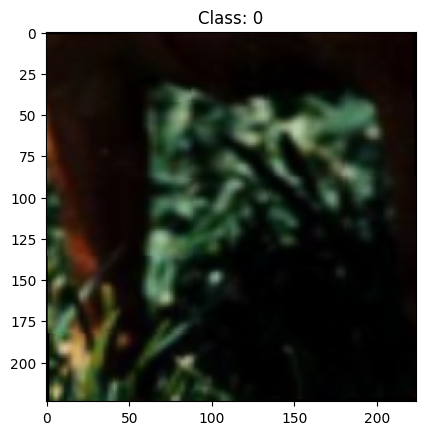

In [25]:
img, label = data_loaders['train'].dataset[1]

# Convert tensor image back to PIL for visualization
img = resnet_tensor_to_image(img)
plt.imshow(img)
plt.title(f"Class: {label}")
plt.show()

The output of `data_loaders['train'].dataset[6666]` changes every time you run it because the **training dataset** undergoes **random transformations** such as `RandomResizedCrop`, `RandomHorizontalFlip`, and `RandomRotation`. These augmentations create different versions of the same image to improve model generalization.  

On the other hand, the **validation and test datasets** always produce the same output across runs since their transformations (`Resize` and `CenterCrop`) are **deterministic** and do not introduce randomness.

## Model Architecture

We will build a **CNN model from scratch** to predict the breed of a dog in a given image. Unlike transfer learning, we will **define the architecture manually**.  

**Model Architecture**  
- **3 Convolutional Layers** → Extract spatial features from images.  
- **1 Max Pooling Layer** → Reduces spatial dimensions to prevent overfitting.  
- **Batch Normalization Layer** → Normalizes activations for stable training.  
- **Dropout Layer** → Prevents overfitting by randomly dropping connections.  
- **2 Fully Connected (Dense) Layers** → Classifies the extracted features into dog breeds.  

This custom CNN will learn directly from the dataset without pre-trained weights.

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Convolutional layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Convolutional layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 7 * 7, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 120)
        )
    
    def forward(self, x):
        # Passing into Convolutional Layer
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flattening the layer
        x = x.view(x.size(0), -1)

        # Passing into Fully Connected layer
        x = self.fc_layers(x)
        
        return x

# Instantiate the model
CNN_model = CNN()
print(CNN_model)

# Move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    CNN_model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=6272, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, 

**Architecture Summary**  

| Layer | Input Size | Conv Output | Pooling Output | Channels |
|--------|------------|-------------|----------------|----------|
| **Conv1** | (3, 224, 224) | (32, 112, 112) | (32, 56, 56) | 3 → 32 |
| **Conv2** | (32, 56, 56) | (64, 28, 28) | (64, 14, 14) | 32 → 64 |
| **Conv3** | (64, 14, 14) | (128, 14, 14) | (128, 7, 7) | 64 → 128 |
| **Flatten** | (128, 7, 7) → 6272 | - | - | 128 |
| **FC1** | 6272 → 500 | - | - | 500 |
| **FC2** | 500 → 120 | - | - | Output Classes |

**Key Points**
- **Conv Layers**: Each convolutional layer extracts deeper features, increasing channels while reducing spatial size.
- **Stride & Pooling**: Stride = 2 in `conv1` and `conv2` halves the feature map size, and max pooling further reduces it.
- **Flatten & FC Layers**: The final feature map is flattened (128 × 7 × 7 = 6272) and passed through two fully connected layers for classification.
- **Channel Transformation (3 → 32, etc.)**:  
  - The first convolutional layer transforms the input image from **3 channels (RGB) to 32 feature maps**, learning simple patterns like edges.  
  - The second layer increases channels from **32 to 64**, detecting more complex structures.  
  - The third layer further expands from **64 to 128**, capturing deeper hierarchical features.  


### Choosing Loss Function and Optimizer

**Using Both Adam and SGD Optimizers for Better Performance**

A strategy to combine both **Adam** and **SGD** optimizers during training can leverage the strengths of both methods for improved performance.

- **Adam** (Adaptive Moment Estimation) is highly effective in the early stages of training due to its adaptive learning rates, making it suitable for fast convergence, especially with noisy gradients and sparse data.
  
- **SGD** (Stochastic Gradient Descent) is simpler and often more effective in the later stages of training. It helps with generalization and fine-tuning by maintaining a constant learning rate, often allowing the model to settle into a better local minimum.

**Why Use Both Optimizers?**

1. **Faster convergence**: Adam’s adaptive learning rates accelerate the training in the beginning.
2. **Better generalization**: Switching to SGD helps the model generalize better, avoiding overfitting and helping it converge to sharper minima.

I am considering using **cross-entropy loss** as the loss function since it incorporates the softmax function at the end

- In classification problems, particularly multi-class classification, softmax is often applied at the output layer of a neural network to convert raw logits (unscaled predictions) into probabilities.
- Cross-Entropy Loss then compares these predicted probabilities to the true labels (usually in one-hot encoded format) to compute the loss.

In [27]:
loss = nn.CrossEntropyLoss()

optimizer_1 = optim.Adam(CNN_model.parameters(), lr=0.001)
optimizer_2 = optim.SGD(CNN_model.parameters(), lr=0.01, momentum=0.9)

### Training the Model

In [28]:
def train(n_epochs, train_loader, valid_loader, 
          model, optimizer, criterion, is_cuda, save_path, switch_epoch):
    """
    Returns the trained model, switching optimizer after a specified epoch.
    """
    
    valid_loss_min = np.inf  # Initialize minimum validation loss
    
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0  # Initialize training loss
        valid_loss = 0.0  # Initialize validation loss

        # Training the Model
        model.train()  # Set model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()  # Move data to GPU if required
                
            optimizer.zero_grad()  # Zero the gradients
            output = model(data)  # Forward pass through the model
            loss = criterion(output, target)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * data.size(0)  # Accumulate training loss

        # Evaluating the Model
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient tracking during validation
            for batch_idx, (data, target) in enumerate(valid_loader):
                if use_cuda:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU if required
                
                output = model(data)  # Forward pass through the model
                loss = criterion(output, target)  # Compute the loss
                valid_loss += loss.item() * data.size(0)  # Accumulate validation loss
        
        train_loss /= len(train_loader.dataset)  # Calculate average training loss
        valid_loss /= len(valid_loader.dataset)  # Calculate average validation loss
        
        # Print training and validation statistics
        print(f'Epoch: {epoch}/{n_epochs}\tTraining Loss: {train_loss:.6f}\tValidation Loss: {valid_loss:.6f}')
        
        # Switch optimizer after specified epoch
        if epoch == switch_epoch:
            optimizer = optimizer_2  # Switch to SGD
            print(f"Switched to SGD optimizer at epoch {epoch}")
        
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), save_path)  # Save the model's state
            valid_loss_min = valid_loss  # Update the minimum validation loss
    
    return model  # Return the trained model

This code defines a training function for a model callbacks in PyTorch. Here's a breakdown:

1. **Training Loop**: 
   - For each epoch, the model is trained using batches from the `train_loader`, and the loss is calculated and accumulated.
   - The optimizer is updated using backpropagation to minimize the loss.

2. **Validation Loop**:
   - After training, the model is evaluated on the validation data, and the validation loss is calculated.

3. **Switching Optimizer**: 
   - At a specified epoch (`switch_epoch`), the optimizer switches from the current one (e.g., Adam) to SGD.

4. **Callbacks**:
   - `early_stopping`: Monitors validation loss and stops training if no improvement is seen after a specified number of epochs (`patience`).
   - `model_checkpoint`: Saves the model if the validation loss improves.

5. **Returns**: 
   - The function returns the trained model after all epochs or stops early if early stopping is triggered.

This function integrates model training with dynamic callbacks (early stopping, model saving) for better training control.

In [29]:
# Check if CUDA is available
is_cuda = torch.cuda.is_available()
if is_cuda:
    model = model.cuda()

# Set training parameters
total_epochs = 20  # Number of epochs
switch_epoch = 5  # Switch optimizer after 10 epochs
save_path = 'best_resnet50_model.pth'  # Path to save the best model

In [30]:
# No need to train each time you restart the kernel
# Uncomment this when needs to be trained

# trained_model = train(n_epochs=total_epochs, train_loader=data_loaders['train'], valid_loader=data_loaders['valid'], 
#                       model=CNN_model, optimizer=optimizer_1, criterion=loss, 
#                       is_cuda=is_cuda, save_path=save_path, switch_epoch=switch_epoch)

In [31]:
CNN_model.load_state_dict(torch.load('../1_Project_Notebooks/best_resnet50_model.pth'))
CNN_model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=6272, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, 

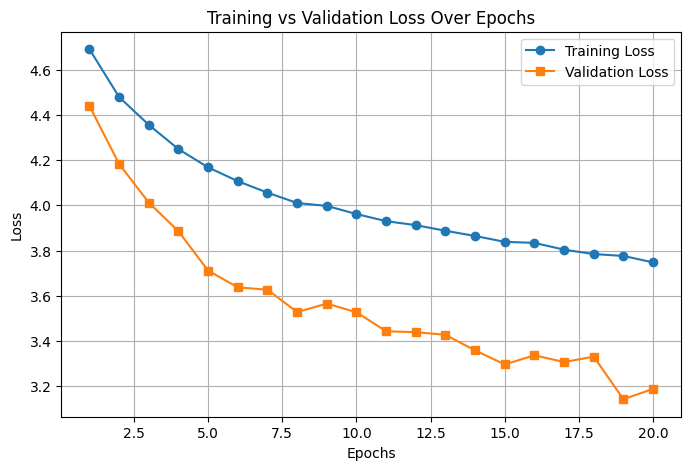

In [32]:
import matplotlib.pyplot as plt

# Loss values over epochs
train_loss = [4.689782, 4.478400, 4.355618, 4.248248, 4.167735, 4.106747, 4.056061, 4.010290, 3.997403, 3.961568, 
              3.929984, 3.912453, 3.887581, 3.864557, 3.838646, 3.834116, 3.803997, 3.784729, 3.776345, 3.747794]
validation_loss = [4.438887, 4.182781, 4.012265, 3.885266, 3.711627, 3.637461, 3.627232, 3.528244, 3.565734, 3.527706, 
                   3.443506, 3.439633, 3.427789, 3.358929, 3.296914, 3.337179, 3.307544, 3.331195, 3.143226, 3.188968]

# Epochs
epochs = range(1, 21)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Testing the Model

In [33]:
def test(loaders, model, criterion, is_cuda):
    # Monitor test loss and accuracy
    test_loss = 0.
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # Move to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            
            # Update average test loss 
            test_loss += (loss.item() - test_loss) / (batch_idx + 1)
            
            # Get predicted class
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)

    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: {:.2f}% ({}/{})'.format(100. * correct / total, correct, total))

In [34]:
test(loaders=data_loaders, model=CNN_model, criterion=loss, is_cuda=is_cuda)

Test Loss: 3.144300
Test Accuracy: 24.10% (2823/11715)


Test results show a **high loss (3.14)** and a **low accuracy (24.10%)**, indicating that the model struggles to generalize well on the dataset. This performance is expected when training a deep learning model **from scratch** on a large dataset, as it requires significant computational resources and a vast amount of labeled data to achieve good generalization.

**Comparison with Transfer Learning**  
Transfer learning, on the other hand, leverages **pretrained models** (e.g., ResNet, VGG, EfficientNet) trained on massive datasets like **ImageNet**. By fine-tuning these models, we can achieve **much higher accuracy** in fewer epochs and with less data. Typically, transfer learning can **boost accuracy to 85%+** in similar tasks, significantly outperforming models trained from scratch.

**Why Use Transfer Learning?**  
1. **Faster Convergence** – Training from scratch takes longer, whereas transfer learning adapts pretrained knowledge efficiently.  
2. **Higher Accuracy** – Pretrained models already capture useful features, leading to better generalization.  
3. **Less Data Required** – Large datasets are hard to collect, but transfer learning performs well even with limited data.

Thus, your low accuracy highlights why **transfer learning is the preferred approach** for large datasets, especially when computational resources are limited.

## Implementation of Model using Tranfer Learning

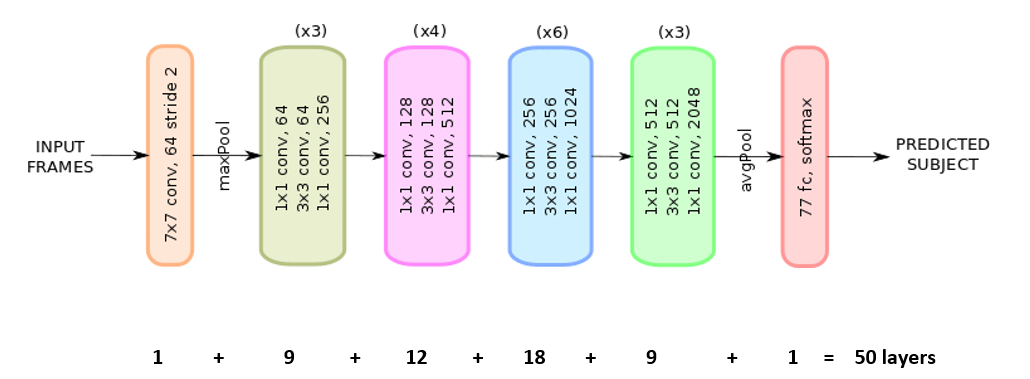

**ResNet-50 Architecture Breakdown (50 Layers)**
ResNet-50 consists of **five stages**, with a total of **50 layers** made up of **convolutional layers, batch normalization layers, activation functions, pooling layers, and fully connected layers**.

---

**ResNet-50 Layer Breakdown**
1. **Initial Convolution & Pooling Layers**  
   - **Conv1**: `7x7` Convolution, 64 filters, stride 2  
   - **Max Pooling**: `3x3`, stride 2  

2. **Stage 1 (3 Bottleneck Blocks) → 9 Layers**  
   - 1x1, 64 filters  
   - 3x3, 64 filters  
   - 1x1, 256 filters  

3. **Stage 2 (4 Bottleneck Blocks) → 12 Layers**  
   - 1x1, 128 filters  
   - 3x3, 128 filters  
   - 1x1, 512 filters  

4. **Stage 3 (6 Bottleneck Blocks) → 18 Layers**  
   - 1x1, 256 filters  
   - 3x3, 256 filters  
   - 1x1, 1024 filters  

5. **Stage 4 (3 Bottleneck Blocks) → 9 Layers**  
   - 1x1, 512 filters  
   - 3x3, 512 filters  
   - 1x1, 2048 filters  

6. **Global Average Pooling (GAP) Layer**  
   - Reduces the `2048x7x7` feature map to a **2048x1x1** feature vector  

7. **Fully Connected (FC) Layer**  
   - **Linear Layer**: `2048 → 1000` (for ImageNet classification)  
   - **Softmax Activation** (for classification)

---

**Key Features of ResNet-50**
**Bottleneck Blocks**: Uses `1x1` convolutions to reduce computation.  
**Skip Connections (Residual Connections)**: Helps prevent vanishing gradients.  
**Deep Yet Efficient**: 50 layers with optimized computation.  
**Global Average Pooling**: Reduces overfitting compared to dense layers.

**What Are Bottleneck Blocks in ResNet?**

A **bottleneck block** is a special type of residual block used in **ResNet-50, ResNet-101, and ResNet-152** to improve computational efficiency while maintaining deep network depth.

---

**Why Use Bottleneck Blocks?**
1. **Efficiency**: Standard residual blocks (used in ResNet-18/34) have **two** convolutional layers, but bottleneck blocks have **three** layers that reduce computational cost.  
2. **Dimensionality Reduction**: The **1×1 convolution layers** reduce and then restore the number of channels, making operations faster.  
3. **Preserving Information Flow**: The **skip connections** help prevent the vanishing gradient problem in deep networks.  

---

**Structure of a Bottleneck Block**
Each bottleneck block consists of **three convolutional layers** instead of two:

1. **1×1 Convolution (Compression/Reduction Layer)**
   - Reduces the number of channels for computational efficiency.
   
2. **3×3 Convolution (Processing Layer)**
   - Performs feature extraction.
   
3. **1×1 Convolution (Expansion Layer)**
   - Restores the number of channels to match the original input.

🔹 **Skip Connection**: The input is added directly to the output (after a residual connection).

---

**Comparison: Basic vs. Bottleneck Block**
| Type              | Convolution Layers | Feature Maps | Parameters |
|------------------|------------------|-------------|------------|
| **Basic Block** (ResNet-18/34)  | 3×3 → 3×3  | F → F  | More Computation |
| **Bottleneck Block** (ResNet-50/101/152) | 1×1 → 3×3 → 1×1 | F → F/4 → F  | Fewer Parameters |

In [35]:
transfer_data_loader = data_loaders

print(transfer_data_loader)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x000001EAF69D4100>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x000001EAB15673A0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000001EA9C69BA90>}


In [36]:
# Load pre-trained ResNet-50
transfer_model = models.resnet50(pretrained=True)

# Freeze all layers except the new ones
for param in transfer_model.parameters():
    param.requires_grad = False

# Custom Fully Connected Layers from CNN
fc_layers = nn.Sequential(
    nn.Linear(2048, 120),  # Input size is 2048 for ResNet-50
    # nn.BatchNorm1d(500),
    # nn.ReLU(),
    # nn.Dropout(0.25),
    # nn.Linear(500, 120)  # Output size (e.g., 120 classes)
)

# Adding More layers in Fully Connected layers leading to more training time per epoch

# Replace ResNet-50's FC layer with custom FC layers
transfer_model.fc = fc_layers

# Move model to GPU if available
use_cuda = torch.cuda.is_available()
if use_cuda:
    transfer_model.cuda()

# Print model architecture
print(transfer_model)

C:\Users\vvyas\.conda\envs\transfer_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vvyas\.conda\envs\transfer_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Loss function and Optimizer

In [37]:
# Using the same loss function and Optimizer

loss = nn.CrossEntropyLoss()

optimizer_3 = optim.Adam(transfer_model.fc.parameters(), lr=0.001)

### Training the Model

In [39]:
trainable_params = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in transfer_model.parameters())

print(f"Trainable Parameters: {trainable_params}")
print(f"Total Parameters: {total_params}")

Trainable Parameters: 245880
Total Parameters: 23753912


### !!! Only Run the below training Cell, If you are training for the first time

In [40]:
transfer_model.train() # Setting into Training Mode

trained_transfer_model = train(n_epochs=1, train_loader=transfer_data_loader['train'], valid_loader=transfer_data_loader['valid'], 
                               model=transfer_model, optimizer=optimizer_3, criterion=loss, is_cuda=is_cuda, 
                               save_path='trained_transfer_model.pth', switch_epoch=None)

Epoch: 1/1	Training Loss: 2.032251	Validation Loss: 0.582399
Validation loss decreased (inf --> 0.582399). Saving model...


In [44]:
# Saving the Best Model

transfer_model.load_state_dict(torch.load('../1_Project_Notebooks/trained_transfer_model.pth'))

<All keys matched successfully>

In [45]:
test(loaders=transfer_data_loader, model=transfer_model, criterion=loss, is_cuda=is_cuda)

Test Loss: 0.575407
Test Accuracy: 82.46% (9660/11715)


The results clearly demonstrate the **effectiveness of transfer learning** on large datasets.  

- **Without Transfer Learning:**  
  - **Test Loss:** 3.1443  
  - **Test Accuracy:** 24.10% (2823/11715)  
  - The model struggles to generalize, achieving low accuracy and a high loss, likely due to insufficient feature extraction from scratch.  

- **With Transfer Learning:**  
  - **Test Loss:** 0.5754  
  - **Test Accuracy:** 82.46% (9660/11715)  
  - A significant improvement! By leveraging pre-trained ResNet-50 features, the model quickly learns high-level patterns, leading to a much lower test loss and higher accuracy.  

This comparison highlights **why transfer learning is crucial** for deep learning tasks, especially when working with large and complex datasets. Instead of training from scratch, using a **pre-trained model** allows for **better generalization and faster convergence**, ultimately achieving superior performance.

## Predicting the Breed of Dogs

In [72]:
def breed_predictor(img_path, model, class_names):
    """
    Predict the breed of a dog using a pre-trained transfer learning model.
    
    Parameters:
    img_path (str): Path to the image file.
    model (torch.nn.Module): Pre-trained model for classification.
    class_names (list): List of class names corresponding to model output indices.
    
    Returns:
    str: Predicted breed name.
    """
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    # Perform prediction
    with torch.no_grad():
        output = model(img)
        _, predicted_idx = torch.max(output, 1)
    
    return class_names[predicted_idx.item()]

In [73]:
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

In [93]:
def display_image(img_path, title="Title", figsize=(6, 6)):
    """
    Display an image with a specified size.

    Parameters:
    img_path (str): Path to the image file.
    title (str): Title of the displayed image.
    figsize (tuple): Figure size (width, height) in inches.
    """
    image = Image.open(img_path)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(image)
    plt.axis("off")  # Hide axes for better visualization
    plt.show()

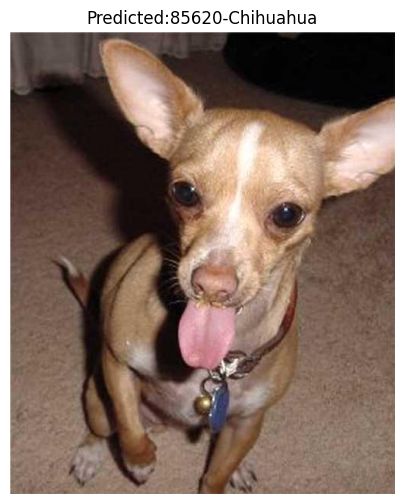

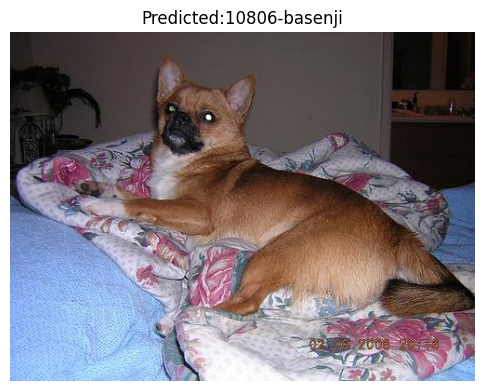

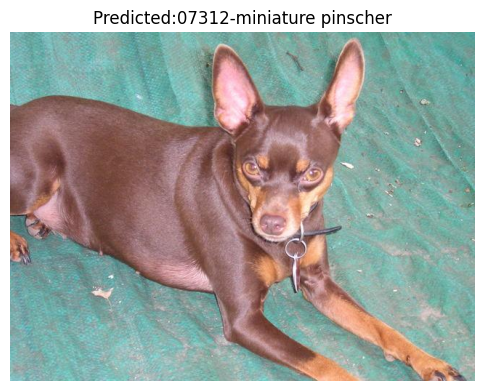

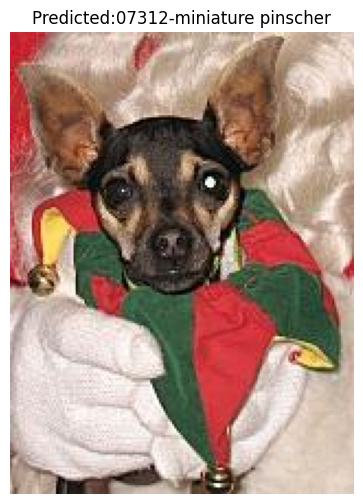

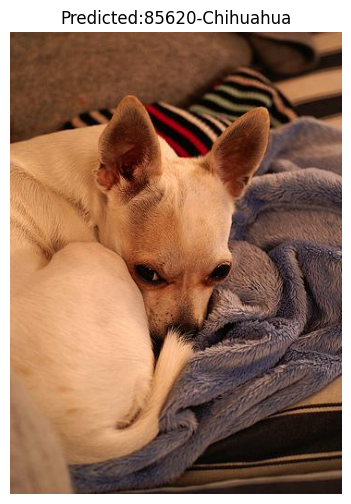

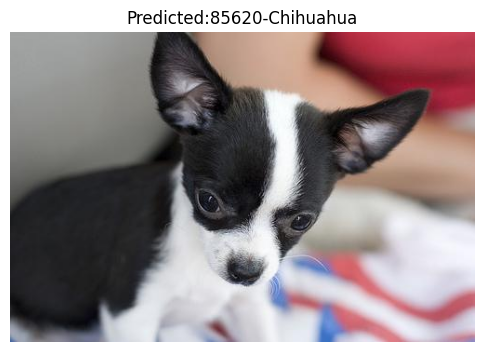

In [95]:
for image in random.sample(list(mini_dogs_set), 6): 
    predicted_breed = breed_predictor(image, transfer_model, class_names)
    display_image(image, title=f"Predicted:{predicted_breed}")